In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Data Import and Examination

In [ ]:
df_credit = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/credit_record.csv')
df_application = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/application_record.csv')

We first examine some sample from the dataset

In [ ]:
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Then we take a more in-depth look at the data

In [ ]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [ ]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
print(df_application['ID'].nunique())
# Drop duplicate
df_application_clean = df_application.drop_duplicates('ID', keep='last')

438510


In [ ]:
print(df_credit['ID'].nunique()) 

45985


#### Label Generation: **Only run once please**

We intend to generate the labels based on STATUS column, indicating whether a person is in debt that month

In [ ]:
# see the number of overdue status
print(df_credit['STATUS'].value_counts() )

# replace the value C and X with 0 as it is the same type (not risky)
df_credit['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)

# change all the values to int so that I can do filtering later
df_credit['STATUS'] = df_credit['STATUS'].astype('int')

# 2,3,4,5 are classified as 1 because they are the same type, overdue for more than 60 days
# 0&1 also to be 0 because not so much overdue
# these will be our labels/prediction results for our model, bad=1,good=0
df_credit['STATUS'] = df_credit['STATUS'].apply(lambda x:1 if x >= 2 else 0)

df_credit['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64


0    1045471
1       3104
Name: STATUS, dtype: int64

In [ ]:
# If a customer have ever overdue by 60 days, we will classify him as a bad customer
# Need to reset index otherwise the ID column will disappear??
df_credit_clean = df_credit.groupby('ID').agg(max).reset_index()


# roughly 1.5% customers have bad record
# It is mentioned by the dataset provider that generally 3% of the customers are bad customers,
# So this value is reasonable for us
df_credit_clean['STATUS'].value_counts() 


0    45318
1      667
Name: STATUS, dtype: int64

In [ ]:
len(set(df_credit_clean['ID']).intersection(set(df_application_clean['ID'])))

36457

intersection is only 36457, meaning only 36457 people have both credit report and other informations(in df_application).

We will only use these people to build our model.



In [ ]:
# Joint dataframe, containing all useful records
# Make ID index, because it is not a feature
df_joint = df_application.join(df_credit_clean.set_index('ID'), on='ID', how='inner')
df_joint.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
len(df_joint)

df_joint.head()
df_joint.to_csv('/content/drive/MyDrive/PG32 CS3244/RawFullData.csv', index=False)

#### Data Pre-processing

We observe several issues with the data:


1. Some of the columns have several null values. In this case, is the occupation column.
2. There could be some outliers in the data
3. Encoding the categorical variables
4. Feature selection





In [ ]:
# 2.
# *** remove outliers?
# Restore data just for testing
app = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/application_record.csv')




print("Before removing outliers")
print("size of df_application")
print(len(app))
print("number of useful records from both df")
print(len(set(df_credit_clean['ID']).intersection(set(app['ID']))))




# FOR CNT_CHILDREN COLUMN
q_hi = app['CNT_CHILDREN'].quantile(0.999)
q_low = app['CNT_CHILDREN'].quantile(0.001)
app = app[(app['CNT_CHILDREN']>q_low) & (app['CNT_CHILDREN']<q_hi)]
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = app['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = app['AMT_INCOME_TOTAL'].quantile(0.001)
app= app[(app['AMT_INCOME_TOTAL']>q_low) & (app['AMT_INCOME_TOTAL']<q_hi)]
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = app['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = app['CNT_FAM_MEMBERS'].quantile(0.001)
app= app[(app['CNT_FAM_MEMBERS']>q_low) & (app['CNT_FAM_MEMBERS']<q_hi)]

print("Before removing outliers")
print("size of df_application")
print(len(app))
print("number of useful records from both df")
print(len(set(df_credit_clean['ID']).intersection(set(app['ID']))))
# We removed too many data... I don't think this is good
# So I will not be using such data later




Before removing outliers
size of df_application
438557
number of useful records from both df
36457
Before removing outliers
size of df_application
114201
number of useful records from both df
9516


##### Encoding

In [ ]:
#Let us first have a look at the dataset
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114201 entries, 29 to 438548
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   114201 non-null  int64  
 1   CODE_GENDER          114201 non-null  object 
 2   FLAG_OWN_CAR         114201 non-null  object 
 3   FLAG_OWN_REALTY      114201 non-null  object 
 4   CNT_CHILDREN         114201 non-null  int64  
 5   AMT_INCOME_TOTAL     114201 non-null  float64
 6   NAME_INCOME_TYPE     114201 non-null  object 
 7   NAME_EDUCATION_TYPE  114201 non-null  object 
 8   NAME_FAMILY_STATUS   114201 non-null  object 
 9   NAME_HOUSING_TYPE    114201 non-null  object 
 10  DAYS_BIRTH           114201 non-null  int64  
 11  DAYS_EMPLOYED        114201 non-null  int64  
 12  FLAG_MOBIL           114201 non-null  int64  
 13  FLAG_WORK_PHONE      114201 non-null  int64  
 14  FLAG_PHONE           114201 non-null  int64  
 15  FLAG_EMAIL      

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# I think some algorithms require encoding so we just do it
df_encoded = df_joint.copy()
for x in df_encoded:
  if df_encoded[x].dtypes=='object':
    df_encoded[x] = le.fit_transform(df_encoded[x])
    print(len(list(le.classes_)), list(le.classes_))

# Also, number of family member should be int
df_encoded = df_encoded.astype({'CNT_FAM_MEMBERS':'int'})

2 ['F', 'M']
2 ['N', 'Y']
2 ['N', 'Y']
5 ['Commercial associate', 'Pensioner', 'State servant', 'Student', 'Working']
5 ['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special']
5 ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Widow']
6 ['Co-op apartment', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'With parents']
19 ['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', 'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff', nan]


In [ ]:
df_joint.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [ ]:
df_encoded.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,18,2,0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,18,2,0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,16,2,0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1,0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1,0


From above, we observe that the first three categorical variables are effectively turned into one-hot encoding variables, while the remaining five are not.

In the end, our group decided to utilise label-encoding for two reasons:

1. Since many of our categorical variables have many classes (up to 19), our dimensionality will explode if we use one-hot encoding. Our tree methods does suffer from the curse of dimensionality. 
2. Many of our features can be considered as being ordinal. E.g. the level of education. This justifies our use of label encoding in some cases.

To reflect 2, we need to re-encode the dataset :(

In [ ]:
OrdEdu = ['Lower secondary', 'Secondary / secondary special','Incomplete higher','Higher education', 'Academic degree']
OrdHome = ['With parents','Rented apartment', 'Co-op apartment','Office apartment', 'House / apartment', 'Municipal apartment']

df_encoded1 = df_joint.copy()

#Transform the columns that are considered to be ordinal
df_encoded1['NAME_EDUCATION_TYPE'] = df_encoded1['NAME_EDUCATION_TYPE'].apply(lambda x: OrdEdu.index(x))
df_encoded1['NAME_HOUSING_TYPE'] = df_encoded1['NAME_HOUSING_TYPE'].apply(lambda x: OrdHome.index(x))

for x in df_encoded1:
  if df_encoded1[x].dtypes=='object':
    df_encoded1[x] = le.fit_transform(df_encoded1[x])
    print(len(list(le.classes_)), list(le.classes_))

# Also, number of family member should be int
df_encoded1 = df_encoded1.astype({'CNT_FAM_MEMBERS':'int'})

2 ['F', 'M']
2 ['N', 'Y']
2 ['N', 'Y']
5 ['Commercial associate', 'Pensioner', 'State servant', 'Student', 'Working']
5 ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Widow']
19 ['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', 'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff', nan]


##### kNN Imputation for the missing values

In the above sections, we observed that there are considerable missing values for OCCUPATION_TYPE. We believe that we could use kNN imputation to generate the labels.

array([[5.008804e+06, 1.000000e+00, 1.000000e+00, ..., 1.800000e+01,
        2.000000e+00, 0.000000e+00],
       [5.008805e+06, 1.000000e+00, 1.000000e+00, ..., 1.800000e+01,
        2.000000e+00, 0.000000e+00],
       [5.008806e+06, 1.000000e+00, 1.000000e+00, ..., 1.600000e+01,
        2.000000e+00, 0.000000e+00],
       ...,
       [5.149838e+06, 0.000000e+00, 0.000000e+00, ..., 1.100000e+01,
        2.000000e+00, 1.000000e+00],
       [5.150049e+06, 0.000000e+00, 0.000000e+00, ..., 1.400000e+01,
        2.000000e+00, 1.000000e+00],
       [5.150337e+06, 1.000000e+00, 0.000000e+00, ..., 8.000000e+00,
        1.000000e+00, 1.000000e+00]])

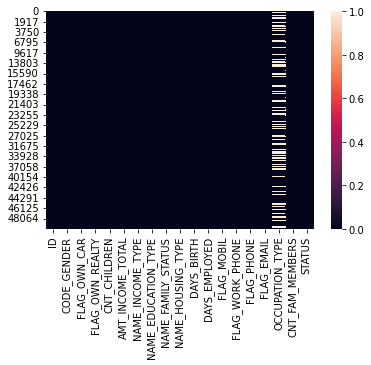

In [ ]:
import seaborn as sns
df_joint_fillna = df_joint.copy()
#df_joint_fillna = df_joint_fillna.fillna("na")
sns.heatmap(df_joint_fillna.isnull())


from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, missing_values = 19)

imputer.fit_transform(df_encoded1)

In [ ]:
#Check if number 19, formerly representing NULL, has been removed from the OCCUPATION_TYPE column
set(df_encoded1["OCCUPATION_TYPE"])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

####  Feature Selection
Some people online did feature selection by looking at Information value / correlation

In our case, the list of our features are as follows:

1. Gender
2. Own car
3. Own real estate
4. Children Number
5. Total Annual Income
6. Type of Income
7. Type of education
8. Family Status
9. Type of Housing
10. Days from birth
11. Days Employed
12. Have mobile number
13. Have work phone
14. Have phone
15. Have email
16. Type of occupation
17. Family Number

Label is only Status: whether the person is consider to have 'defaulted' or not

But I think since we have very little feature it is not necessary
Maybe we can still mentioned it in our report to show that we are aware

###### Gender

In [ ]:
defaultSex = df_encoded1.groupby("STATUS").CODE_GENDER.value_counts()
defaultSex

STATUS  CODE_GENDER
0       0              24051
        1              11790
1       0                379
        1                237
Name: CODE_GENDER, dtype: int64

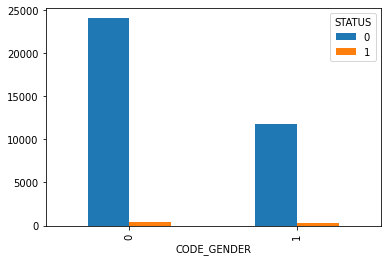

In [ ]:
defaultSex.unstack(level=0).plot(kind='bar', subplots=False)

##### Possible Useless Feature: FLAG_MOBIL

During initial stages of data examination, the team have soptted that this feature is quite uesless.

In [ ]:
defaultMobile = df_encoded1.groupby("STATUS").FLAG_MOBIL.value_counts()
defaultMobile

STATUS  FLAG_MOBIL
0       1             35841
1       1               616
Name: FLAG_MOBIL, dtype: int64

It seems that is feature has only one class...so let's get rid of it

###### Information Gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = df_encoded1.iloc[:,1:-1] # all the variables
y = df_encoded1.iloc[:,-1] # labels
X.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

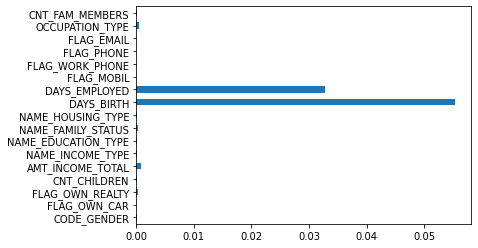

In [ ]:
IG = mutual_info_classif(X, y, random_state = 42, 
                         discrete_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16])
feature_IG = pd.Series(IG, df_encoded1.columns[1:len(df_encoded1.columns)-1])
feature_IG.plot(kind = 'barh')

In [ ]:
feature_IG

CODE_GENDER            0.000114
FLAG_OWN_CAR           0.000009
FLAG_OWN_REALTY        0.000239
CNT_CHILDREN           0.000060
AMT_INCOME_TOTAL       0.000827
NAME_INCOME_TYPE       0.000151
NAME_EDUCATION_TYPE    0.000095
NAME_FAMILY_STATUS     0.000265
NAME_HOUSING_TYPE      0.000140
DAYS_BIRTH             0.055366
DAYS_EMPLOYED          0.032835
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000016
FLAG_PHONE             0.000001
FLAG_EMAIL             0.000003
OCCUPATION_TYPE        0.000533
CNT_FAM_MEMBERS        0.000132
dtype: float64

From the observed Information Gain above, we believe that it might be appropriate to remove FLAG_MOBIL, FLAG_PHONE, and FLAG_EMAIL from the feature list, as it has extremely low information gain. 

###### Correlation Plot

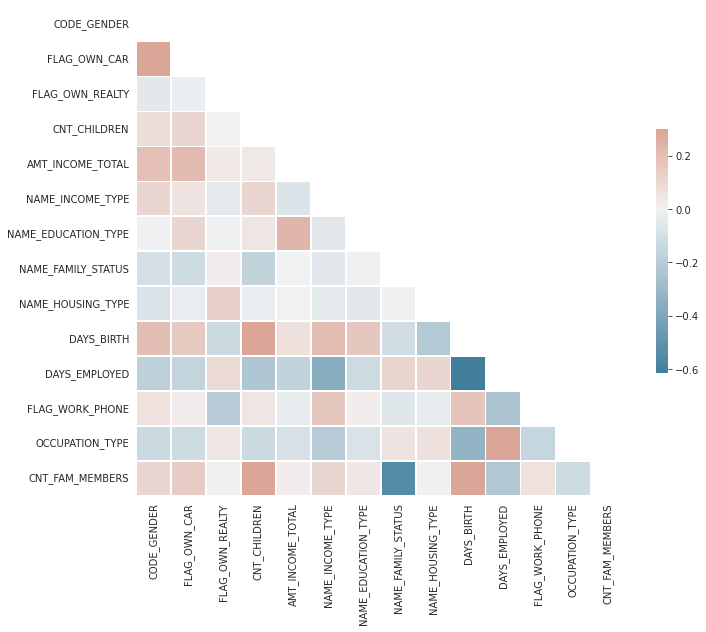

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = X.corr()

#Reduce to triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the plot above, we suppose that correlation is not a significant issue. There is no need to remove any features in this stage.

In [ ]:
# Final Changes to the data: remove FLAG_MOBIL, FLAG_PHONE, and FLAG_EMAIL
# Do not run this column more than once

del df_encoded1["FLAG_MOBIL"]
del df_encoded1["FLAG_PHONE"]
del df_encoded1["FLAG_EMAIL"]

KeyError: ignored

##### Scaling

In [ ]:
# Theoretically Scaling is not necessary as the model will figure out the weight eventually,
# But scaling often helps in certain algorithm, for example regression, due to some precision problem in matrix calculation
# We can consider doing the following
#from sklearn.preprocessing import MinMaxScaler
#X = df_encoded.iloc[:,1:-1] # all the variables
#y = df_encoded.iloc[:,-1] # labels
#mms = MinMaxScaler()
#X_scaled = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)
#X_test_scaled = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)

#### Data Imbalance, SMOTE and SMOTENC

Even before actually working on the data, the group suspects that there is a considerable data imbalance. Therefore, we resort to SMOTE to resolve this problem.

In [ ]:
print(df_encoded1['STATUS'].value_counts())

0    35841
1      616
Name: STATUS, dtype: int64


In [ ]:
# Huge imbalance observed
# So use SMOTE to create more instances of bad customers
# Is this a good approach or should we decrease the good customer size? : Can do both

# Split train test set first:
X = df_encoded1.iloc[:,1:-1] # all the variables
y = df_encoded1.iloc[:,-1] # labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS
43977,0,0,0,0,135000.0,4,1,1,4,-13566,-1900,1,6,2
47558,1,1,1,0,315000.0,4,3,3,4,-10328,-543,0,6,1
1538,0,1,1,0,315000.0,0,1,2,4,-18184,-3021,0,8,1
49139,0,0,1,1,180000.0,2,1,3,4,-13467,-3850,0,11,2
17682,1,1,0,1,247500.0,4,1,1,4,-13086,-1931,0,8,3


In [ ]:
# over sampling with SMOTENC
# There exist categorical variable, so we use SMOTENC to do oversampling
from imblearn.over_sampling import SMOTENC
np.random.seed(1)
# To specify these are categorical features

#smote_nc = SMOTENC(categorical_features=[0,1,2,5,6,7,8,11,12,13,14,15], random_state=1)

smote_nc = SMOTENC(categorical_features=[0,1,2,5,6,7,8,11,12,13], random_state=1)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = smote_nc.fit_resample(X_test, y_test)



smoteNCTrain = X_train_balanced.reset_index(drop=True).join(y_train_balanced)
smoteNCTrain.to_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTrain.csv', index=False)

smoteNCTest = X_test_balanced.reset_index(drop=True).join(y_test_balanced)
smoteNCTest.to_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTest.csv', index=False)


In [ ]:
len(smoteNCTrain)

50164

In [ ]:
len(smoteNCTest)

21518

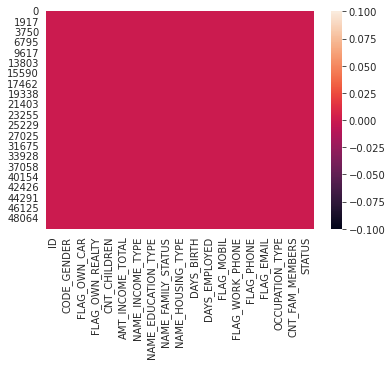

In [ ]:
import seaborn as sns
df_joint_fillna = df_joint.copy()
df_joint_fillna = df_joint_fillna.fillna("na")
sns.heatmap(df_joint_fillna.isnull())

Finally, we examine the data again before putting it into use

In [ ]:
X_train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50164 entries, 0 to 50163
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          50164 non-null  int64  
 1   FLAG_OWN_CAR         50164 non-null  int64  
 2   FLAG_OWN_REALTY      50164 non-null  int64  
 3   CNT_CHILDREN         50164 non-null  int64  
 4   AMT_INCOME_TOTAL     50164 non-null  float64
 5   NAME_INCOME_TYPE     50164 non-null  int64  
 6   NAME_EDUCATION_TYPE  50164 non-null  int64  
 7   NAME_FAMILY_STATUS   50164 non-null  int64  
 8   NAME_HOUSING_TYPE    50164 non-null  int64  
 9   DAYS_BIRTH           50164 non-null  int64  
 10  DAYS_EMPLOYED        50164 non-null  int64  
 11  FLAG_WORK_PHONE      50164 non-null  int64  
 12  OCCUPATION_TYPE      50164 non-null  int64  
 13  CNT_FAM_MEMBERS      50164 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.4 MB


In [ ]:
X_train_balanced.tail()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS
50159,1,1,1,0,202500.000000,4,3,1,4,-17585,-3017,0,4,2
50160,0,0,0,0,108000.000000,1,1,4,4,-22182,365243,0,18,1
50161,0,0,0,0,112500.000000,1,1,1,5,-21363,365243,0,18,2
50162,0,0,1,0,170833.905195,4,1,1,4,-18864,-2633,0,8,2
50163,1,1,0,0,202500.000000,4,1,1,4,-13720,-1394,0,8,2


In [ ]:
y_train_balanced.tail()

50159    1
50160    1
50161    1
50162    1
50163    1
Name: STATUS, dtype: int64

In [ ]:
X_train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50164 entries, 0 to 50163
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          50164 non-null  int64  
 1   FLAG_OWN_CAR         50164 non-null  int64  
 2   FLAG_OWN_REALTY      50164 non-null  int64  
 3   CNT_CHILDREN         50164 non-null  int64  
 4   AMT_INCOME_TOTAL     50164 non-null  float64
 5   NAME_INCOME_TYPE     50164 non-null  int64  
 6   NAME_EDUCATION_TYPE  50164 non-null  int64  
 7   NAME_FAMILY_STATUS   50164 non-null  int64  
 8   NAME_HOUSING_TYPE    50164 non-null  int64  
 9   DAYS_BIRTH           50164 non-null  int64  
 10  DAYS_EMPLOYED        50164 non-null  int64  
 11  FLAG_WORK_PHONE      50164 non-null  int64  
 12  OCCUPATION_TYPE      50164 non-null  int64  
 13  CNT_FAM_MEMBERS      50164 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.4 MB


Some preview of my trying:

1. Using smote to oversample performs better than using `smoteNC`

2. Oversampling the testcases leads to worse performance (compared to using original data to test)